# 2. Original Bell inequality

<center><img src="../../figures/qibo_mascotte/qibo_bell.png" alt="drawing" width="400"/></center>
<center>Qibo and Bell discussing about inequalities at CERN [DALL-E].</center>

### Introduction

_This notebook is an integral part of the paper [Simulating Bell inequalities with Qibo (citation to be added)](), where the popular inequalities concerning quantum Bell states are presented for educational purposes._

In the second of this series, we instantiate a quantum circuit with Qibo to study the violation of the inequality originally introduced by Bell in 1964. Similarly to what done in the previous lecture, let's define the quantity $Q^B$ as:

$$Q^B = |\overline{\alpha\beta} -\overline{\alpha\gamma}| - \overline{\beta\gamma},$$

where $\overline{\alpha\beta} = C(\hat a, \hat b)$ represents the average of the product of the two measurements of $\hat a$ and $\hat b$, that is their _correlation_ (cf. paper). In the assumption of local hidden (LH) variables, the inequality reads:

$$Q^B_{LH} \leq 1$$

We will show that in a Qibo quantum circuit the inequality is violated in the case of entangled particles.

In the [third notebook](./CHSH_inequality.ipynb), we turn to the popular CHSH inequality.


### Setup

Let's start by importing the necessary Python packages. You can install Qibo by executing `pip install qibo` in your environment, see [Qibo Quick start](https://qibo.science/qibo/stable/getting-started/quickstart.html) for further details.

In [1]:
import time
from math import pi

import qibo
from qibo import Circuit, gates

import matplotlib.pyplot as plt

# a dedicated plotting script
from qiboedu.scripts.plotscripts import plot_bell_inequalities

qibo.set_backend(backend="numpy")

[Qibo 0.2.14|INFO|2024-11-12 15:11:39]: Using numpy backend on /CPU:0


Here we instantiate a circuit with free parameters $\phi$ and $\theta$ for the rotations before the measurement. The initial $X$ gates convert a $|0\rangle$ initial state to $|1\rangle$ prior to constructing the Bell state.

In [2]:
c = Circuit(2)
c.add(gates.X(q=0))
c.add(gates.X(q=1))
c.add(gates.H(0))
c.add(gates.CNOT(q0=0, q1=1))
c.add(gates.RZ(q=0, theta=0))
c.add(gates.RZ(q=1, theta=0))
c.add(gates.RY(q=0, theta=0))
c.add(gates.RY(q=1, theta=0))
c.add(gates.M(0, 1))
c.draw()

q0: ─X─H─o─RZ─RY─M─
q1: ─X───X─RZ─RY─M─


Now we define a function to run the simulation for some given values of $\phi_0$, $\phi_1$, $\theta_0$, and $\theta_1$. In this case, the returned value is the _correlation_ $C(q_0, q_1) = \overline{q_0 q_1}$, which is required to compute the $Q^B$ quantity.

We also define a number of parameters for the simulation.

In [3]:
def run_circuit_C(phi_0, phi_1, th_0, th_1):
    '''
    run the simulation for the given choice of ``phi_0``, ``phi_1``, ``theta_0``, ``theta_1``,
    and return the correlation between the two qubits
    '''
    c.set_parameters([phi_0, phi_1, th_0, th_1])
    freqs = c(nshots=nshots).frequencies()
    # return the cross correlation: +1 when q0 = q1, -1 otherwise, averaged over all shots
    return (freqs['00'] + freqs['11'] - freqs['01'] - freqs['10']) / nshots

# parameters for the simulation
ab_steps = 4
phi_steps = 4
ac_steps = 100
nshots = 10000

Now let's run the simulation, and note the computation time. Different Qibo and hardware (e.g. GPU vs CPU) backends may yield significantly different timings.

In [4]:
Q_B = {}
tstart = time.time()
for i_ab in range(ab_steps+1):
    print('Run for theta_ab = %dpi/%d...' % (i_ab, ab_steps))

    th_ab = pi * i_ab/ab_steps    # theta_ab angles go from 0 to pi inclusive
    C_ab = run_circuit_C(0, 0, 0, th_ab)

    Q_B[i_ab] = []

    for i_ac in range(ac_steps+1):
        th_ac = pi * i_ac/ac_steps    # theta_ac angles go from 0 to pi inclusive
        C_ac = run_circuit_C(0, 0, 0, th_ac)
        C_cb = run_circuit_C(0, 0, th_ac, th_ab)
        Q_B[i_ab].append(abs(C_ab - C_ac) - C_cb)

print('Completed in %.1f seconds' % (time.time() - tstart))

Run for theta_ab = 0pi/4...
Run for theta_ab = 1pi/4...
Run for theta_ab = 2pi/4...
Run for theta_ab = 3pi/4...
Run for theta_ab = 4pi/4...
Completed in 1.1 seconds


### Plots

Here we plot the obtained values of $Q^B$ using a dedicated plotscript which can be found in `qiboedu.scripts.plotscripts`.

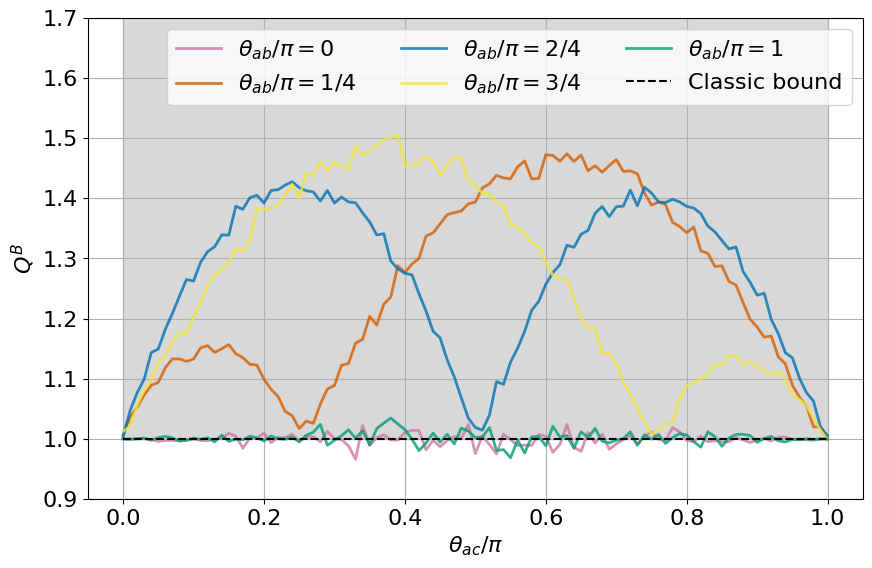

In [5]:
plot_bell_inequalities(
    experiment='bell64', 
    Q_values=Q_B, 
    ac_steps=ac_steps, 
    param_steps=ab_steps, 
    param_label='\\theta_{ab}',
    img_width=1, 
    y_bounds=(0.9, 1.7), 
)

As an additional exercise, we generate a radial plot: this plot better illustrates the evolution of $Q^B$ when changing $\theta_{ac}$ from 0, which corresponds to $\hat{c}$ aligned with the $z$ axis, conventionally represented as the North direction, to $\pi$, which corresponds to $\hat{c}$ pointing to the South direction.

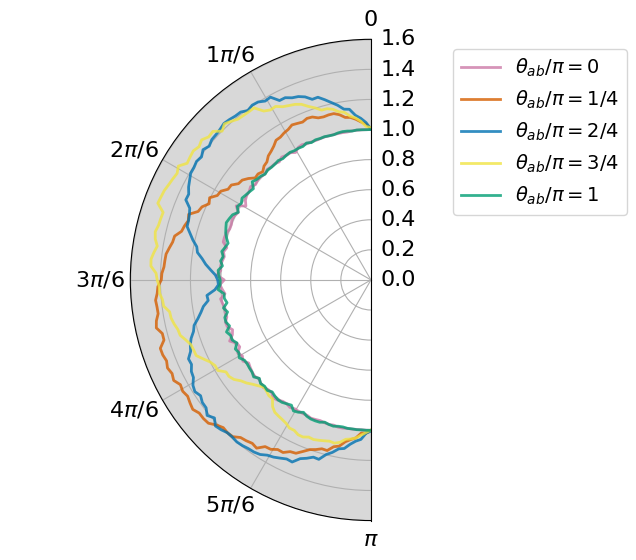

In [6]:
plot_bell_inequalities(
    experiment='bell64', 
    Q_values=Q_B, 
    ac_steps=ac_steps, 
    param_steps=ab_steps, 
    param_label='\\theta_{ab}', 
    y_bounds=(0, 1.6),
    img_width=1, 
    plot_projection='polar', 
)

### Rotation around the _z_ axis

This is an alternate simulation, where for the $c$ measurement we rotate around the $z$ axis by the angle $\phi$ and then around the $y$ axis by the angle $\theta_{ac}$, while we keep $\theta_{ab}$ constant.

The simulation runs over different values of $\phi$ and $\theta_{ac}$.

In [7]:
Qz_B = {}
tstart = time.time()

th_ab = pi/2
C_ab = run_circuit_C(0, 0, 0, th_ab)
for i_phi in range(phi_steps+1):
    print('Run for phi = %dpi/%d...' % (i_phi, phi_steps))

    phi = pi * i_phi/phi_steps    # phi angles go from 0 to pi inclusive
    Qz_B[i_phi] = []

    for i_ac in range(ac_steps+1):
        th_ac = pi * i_ac/ac_steps    # theta_ac angles go from 0 to pi inclusive
        C_ac = run_circuit_C(0, phi, 0, th_ac)
        C_cb = run_circuit_C(phi, 0, th_ac, th_ab)
        Qz_B[i_phi].append(abs(C_ab - C_ac) - C_cb)

print('Completed in %.1f seconds' % (time.time() - tstart))

Run for phi = 0pi/4...
Run for phi = 1pi/4...
Run for phi = 2pi/4...
Run for phi = 3pi/4...
Run for phi = 4pi/4...
Completed in 0.9 seconds


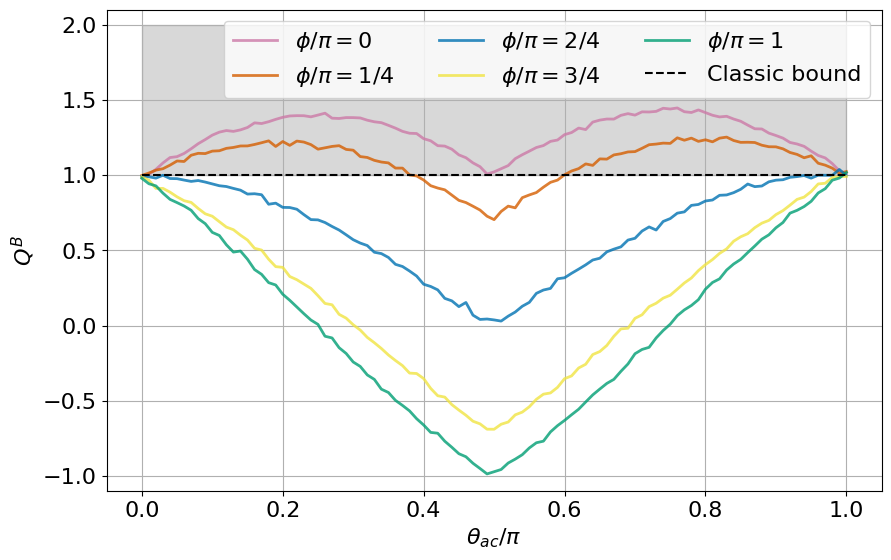

In [8]:
plot_bell_inequalities(
    experiment='bell64', 
    Q_values=Qz_B, 
    ac_steps=ac_steps, 
    param_steps=ab_steps, 
    param_label='\phi', 
    y_bounds=(-1.1, 2.1),
    img_width=1, 
)